# Product analysis

## Contents
[User metrics](#tag_1)
* [Users count](#tag_4)
* [DAU](#tag_2)
* [MAU](#tag_3)
* [Number of paying users](#tag_5)

[Satisfaction metrics](#tag_6)
* [Retention](#tag_7)
* [Average lifetime](#tag_8)

[Engagement metrics](#tag_9)
* [Conversion Rate](#tag_10)

[Monetizationt metrics](#tag_11)
* [ARPU](#tag_12)
* [LTV](#tag_13)

[Performance metrics](#tag_14)
* [Avg session count per user](#tag_15)

## Common functions

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import library_connections as lc

In [9]:
# Plotting result of the query
def plotting_query(query, x, y, xlabel, ylabel, title):
    
    # Reading the data
    df_dau = pd.read_sql(query, lc.create_postgres_uri())

    # Plotting the data
    df_dau.plot(x=x, y=y, kind='line', figsize=(4, 3))
    
    # Setting plot labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)

    # Displaying the plot
    plt.show()

## User metrics<a id='tag_1'></a>

### Users count<a id='tag_4'></a>

Number of new users by month from January to December 2019. Totals and cumulative totals.

In [12]:
query = ''' 

WITH past_users AS (
	SELECT 
		count(distinct user_id) as past_user_count
	FROM
		users
	WHERE
		reg_date < '2019-01-01'
),
	months_count AS (SELECT
		DATE(date_trunc('MONTH', reg_date)) as month,
		count(distinct user_id) as new_user_count
	FROM
		users
	WHERE
		reg_date BETWEEN '2019-01-01' AND '2019-12-31'
	GROUP BY month)

SELECT
	month,
	new_user_count,
	past_user_count + SUM(new_user_count) OVER (ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_user_count
FROM
	past_users, months_count
ORDER BY month;

'''

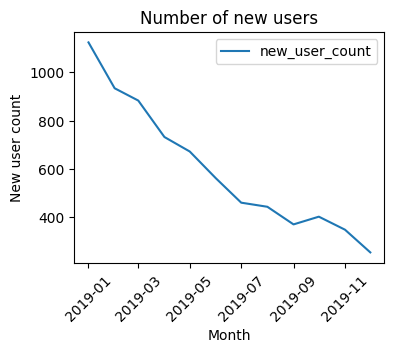

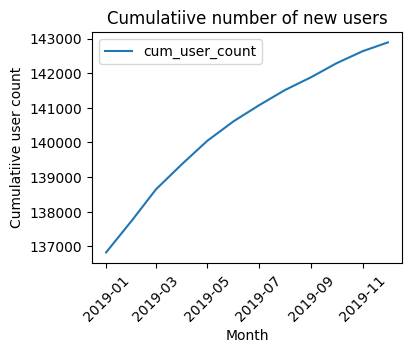

In [13]:
plotting_query(query, 'month', 'new_user_count', 'Month', 'New users count', 'Number of new users')
plotting_query(query, 'month', 'cum_user_count', 'Month', 'Cumulatiive users count', 'Cumulatiive number of new users')

### DAU<a id='tag_2'></a>

Daily active users

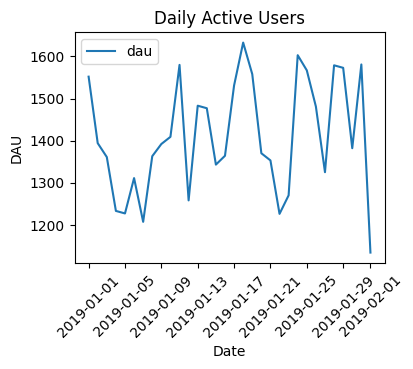

In [10]:
# Plotting DAU
query = """

SELECT
	start_date as date,
	COUNT (DISTINCT user_id) AS dau
FROM
	interactions
WHERE
	start_date BETWEEN '2019-01-01' AND '2019-02-01'
GROUP BY
	start_date;

"""

plotting_query(query, 'date', 'dau', 'Date', 'DAU', 'Daily Active Users')

### MAU<a id='tag_3'></a>

Monthly active users

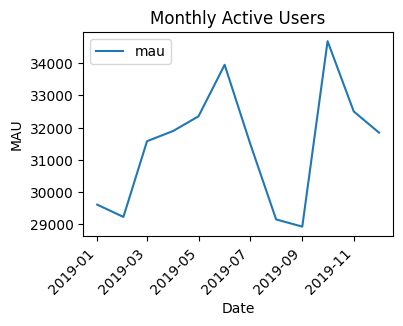

In [11]:
# Plotting MAU
query = """

SELECT
	date_trunc('month', start_date) as date,
	COUNT (DISTINCT user_id) AS MAU
FROM
	interactions
WHERE
	start_date BETWEEN '2019-01-01' AND '2019-12-31'
GROUP BY
	date_trunc('month', start_date);

"""

plotting_query(query, 'date', 'mau', 'Date', 'MAU', 'Monthly Active Users')

### Number of paying users<a id='tag_5'></a>

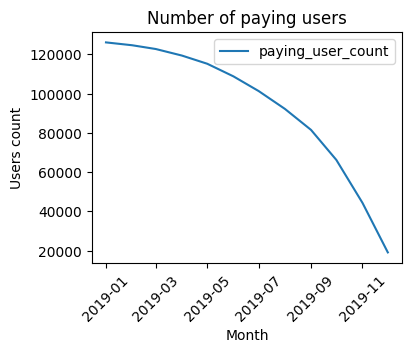

In [16]:
# Plotting Number of paying users
query = """

SELECT
	DATE(date_trunc('MONTH', payment_date)) as month,
	count(distinct user_id) as paying_user_count
FROM
	payments
WHERE
	payment_date BETWEEN '2019-01-01' AND '2019-12-31'
GROUP BY month;

"""

plotting_query(query, 'month', 'paying_user_count', 'Month', 'Users count', 'Number of paying users')

## Satisfaction metrics<a id='tag_6'></a>

### Retention<a id='tag_7'></a>

Retention rate is a metric by which you can evaluate how actively new users continue to use the product. 
Retention is calculated as the percentage of users who return to the product N days after first use.

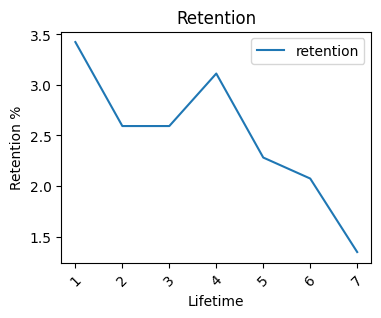

In [23]:
# Retention (January 2019 cohort)
query = """

WITH first_dates AS (
	SELECT
		user_id,
		min(start_date) as first_date
	FROM
		interactions
	WHERE start_date <= '2019-01-31'
	GROUP BY
		user_id
	HAVING
		min(start_date) >= '2019-01-01'
),
total_users AS (
	SELECT count(user_id) AS total_users FROM first_dates
),
lifetimes AS (
	SELECT
		count(distinct f.user_id) AS retained_users,
		i.start_date - f.first_date AS lifetime
	FROM
		first_dates f JOIN interactions i ON f.user_id = i.user_id AND i.start_date < '2019-02-7' AND f.first_date != i.start_date
	WHERE i.start_date - f.first_date <=7
	GROUP BY lifetime
)
SELECT
	l.lifetime,
	l.retained_users,
	tu.total_users AS cohort_size,
	CAST(l.retained_users AS FLOAT) * 100 / tu.total_users AS retention
FROM
	lifetimes l FULL JOIN total_users tu ON TRUE;

"""

plotting_query(query, 'lifetime', 'retention', 'Lifetime', 'Retention %', 'Retention')

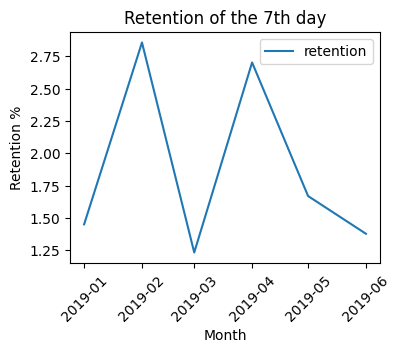

In [21]:
# Retention of the 7th day
query = """

WITH first_dates AS (
	SELECT
		user_id,
		min(start_date) as first_date
	FROM
		interactions
	GROUP BY
		user_id
	HAVING
		min(start_date) BETWEEN '2019-01-01' AND '2019-06-30'
),
-- lifetime = 7
lifetime_filter AS (
	SELECT
		f.user_id,
		f.first_date,
		i.start_date - f.first_date AS lifetime
	FROM
		first_dates f LEFT JOIN interactions i ON f.user_id = i.user_id AND i.start_date < '2019-07-10'
	WHERE
		i.start_date - f.first_date = 7
),
agregation AS (
	SELECT
		date(date_trunc('MONTH', f.first_date)) AS first_month,
		count(distinct l.user_id) AS retained_users,
		count(distinct f.user_id) AS total_users
	FROM
		first_dates f LEFT JOIN lifetime_filter l ON f.user_id = l.user_id
	GROUP BY date(date_trunc('MONTH', f.first_date))
)
SELECT
	first_month,
	retained_users,
	total_users AS cohort_size,
	CAST(retained_users AS FLOAT) * 100 / total_users AS retention
FROM
	agregation;

"""

plotting_query(query, 'first_month', 'retention', 'Month', 'Retention %', 'Retention of the 7th day')

### Average lifetime<a id='tag_8'></a>

How long on average do users stay in the product?

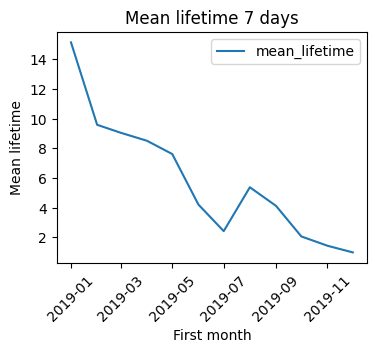

In [24]:
# Retention (January 2019 cohort)
query = """

WITH first_dates AS (
	SELECT
		user_id,
		date(date_trunc('MONTH', min(start_date))) AS first_month,
		min(start_date) as first_date
	FROM
		interactions
	GROUP BY
		user_id
	HAVING
		min(start_date) >= '2019-01-01'
),
total_users AS (
	SELECT
		first_month,
		count(user_id) AS total_users 
	FROM first_dates
	GROUP BY first_month
),
lifetimes AS (
	SELECT
		f.first_month,
		i.start_date - f.first_date AS lifetime,
		count(distinct f.user_id) AS retained_users
	FROM
		first_dates f JOIN interactions i ON f.user_id = i.user_id AND f.first_date != i.start_date
	GROUP BY lifetime, first_month
),
	retention AS (
	SELECT
		l.first_month,
		l.lifetime,
		l.retained_users,
		tu.total_users AS cohort_size,
		CAST(l.retained_users AS FLOAT) / tu.total_users AS retention_rate
	FROM
		lifetimes l FULL JOIN total_users tu ON TRUE
)
SELECT first_month, 
       SUM(retention_rate) AS mean_lifetime 
FROM retention
WHERE lifetime <= 7
GROUP BY first_month
ORDER BY first_month;

"""

plotting_query(query, 'first_month', 'mean_lifetime', 'First month', 'Mean lifetime', 'Mean lifetime 7 days')

## Engagement metrics<a id='tag_9'></a>

### Conversion Rate<a id='tag_10'></a>

Conversion from user registrations to subscription checkout.

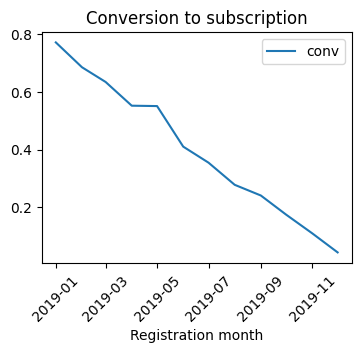

In [30]:
query = """

WITH totals AS (
	SELECT
		date(date_trunc('MONTH', u.reg_date)) AS reg_month,
		count(distinct u.user_id) AS total_users,
		count(distinct pa.user_id) AS subs_users
	FROM
		users u LEFT JOIN payments pa ON pa.user_id = u.user_id
	Group BY date(date_trunc('MONTH', u.reg_date))
)
SELECT
	reg_month,
	CAST(subs_users AS FLOAT) / total_users AS conv
FROM
	totals
WHERE
	reg_month >= '2019-01-01'
ORDER BY reg_month;

"""

plotting_query(query, 'reg_month', 'conv', 'Registration month', '', 'Conversion to subscription')

## Monetizationt metrics<a id='tag_11'></a>

### ARPU<a id='tag_12'></a>

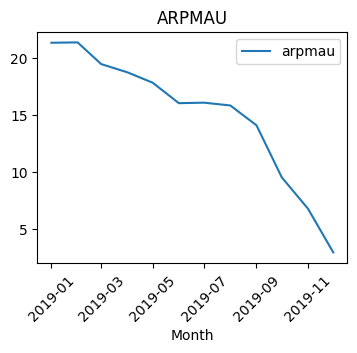

In [29]:
query = """

WITH MAU AS (
	SELECT
		date(date_trunc('MONTH', start_date)) AS month,
		count(distinct user_id) AS MAU
	FROM
		interactions
	GROUP BY month
),
revenue AS (
	SELECT
		date(date_trunc('MONTH', payment_date)) AS month,
		sum(amount) AS revenue
	FROM
		payments
	GROUP BY month
)
SELECT
	m.month,
	CAST(r.revenue AS FLOAT) / m.mau as arpmau
FROM
	mau m LEFT JOIN revenue r ON m.month = r.month
WHERE
	m.month >= '2019-01-01'
ORDER BY m.month;

"""

plotting_query(query, 'month', 'arpmau', 'Month', '', 'ARPMAU')

Given that a monthly subscription costs 5 euros per month, it is evident that at the beginning of the year, 3 out of 4 users subscribed and did not use the service. By the end of the year, the average revenue per user sharply declines.

### LTV<a id='tag_13'></a>

LTV (Lifetime Value) indicates the total revenue a customer has generated over the entire period of using the product. Let's calculate the actual LTV.

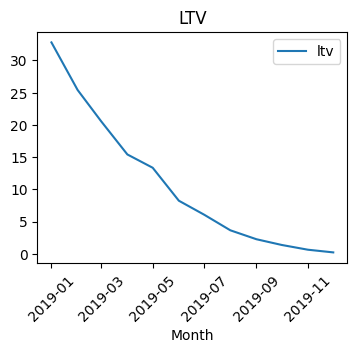

In [28]:
query = """

SELECT
    date(date_trunc('MONTH', u.reg_date)) reg_month,
    SUM(p.amount) / count(distinct u.user_id) AS ltv
FROM
    users u LEFT JOIN payments p ON u.user_id = p.user_id
WHERE
    u.reg_date >= '2019-01-01'
GROUP BY 
    reg_month;

"""

plotting_query(query, 'reg_month', 'ltv', 'Month', '', 'LTV')

## Performance metrics<a id='tag_14'></a>

### Avg session count per user<a id='tag_15'></a>

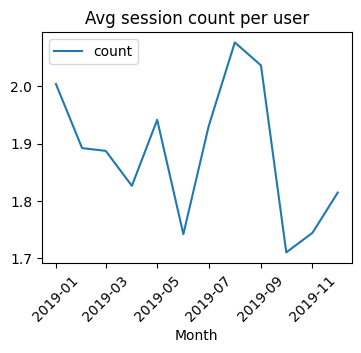

In [32]:
query = """

WITH counts AS (	
SELECT
	date(date_trunc('MONTH', start_date)) AS month,
	count(*) AS total_sessions,
	count(distinct user_id) AS users_count
FROM
	interactions
WHERE
	start_date >= '2019-01-01'
GROUP BY
	month
)
SELECT
	month,
	CAST(total_sessions AS FLOAT) / users_count AS count
FROM
	counts
ORDER BY
	month;

"""

plotting_query(query, 'month', 'count', 'Month', '', 'Avg session count per user')